# HyperStyle Domain Adaptation Notebook

In the paper, we show that the weight offsets predicted by HyperStyle over the FFHQ domain are also applicable on fine-tuned generators such as toonify and StyleGAN-NADA. We demonstrate this idea below.

## Prepare Environment and Download HyperStyle Code

In [1]:
#@title Clone HyperStyle Repo and Install Ninja { display-mode: "form" } 
import os
# os.chdir('./')
CODE_DIR = './'

## clone repo
# !git clone https://github.com/yuval-alaluf/hyperstyle.git $CODE_DIR

## install ninja
# !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
# !sudo unzip ninja-linux.zip -d /usr/local/bin/
# !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

os.chdir(f'./{CODE_DIR}')

In [21]:
from tqdm import tqdm
import imageio
from IPython.display import HTML
from base64 import b64encode

ModuleNotFoundError: No module named 'imageio'

In [2]:
#@title Import Packages { display-mode: "form" }
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

# from notebooks.notebook_utils import Downloader, HYPERSTYLE_PATHS, W_ENCODERS_PATHS, FINETUNED_MODELS, RESTYLE_E4E_MODELS, run_alignment

from notebooks.notebook_utils import HYPERSTYLE_PATHS, W_ENCODERS_PATHS, FINETUNED_MODELS, RESTYLE_E4E_MODELS, run_alignment

from utils.common import tensor2im
from utils.inference_utils import run_inversion
from utils.domain_adaptation_utils import run_domain_adaptation
from utils.model_utils import load_model, load_generator

%load_ext autoreload
%autoreload 2

/data2/svo0175/hyperstyle/venv/lib64/python3.6/site-packages/torch/utils/cpp_extension.py:298: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  platform=sys.platform))
/data2/svo0175/hyperstyle/venv/lib64/python3.6/site-packages/torch/utils/cpp_extension.py:298: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Define Download Configuration
Select below whether you wish to download all models using `pydrive`. Note that if you do not use `pydrive`, you may encounter a "quota exceeded" error from Google Drive.

In [3]:
# #@title Download Configuration { display-mode: "form" }
# download_with_pydrive = True #@param {type:"boolean"}
# downloader = Downloader(code_dir=CODE_DIR, use_pydrive=download_with_pydrive)

## Define Fine-tuned Generator Type

In [4]:
#@title { display-mode: "form" }
generator_type = 'toonify' #@param ['toonify', 'pixar', 'sketch', 'disney_princess']

## Define and Download All Models

In [5]:
#@title Download HyperStyle model { display-mode: "form" }
hyperstyle_path = "./pretrained_models/hyperstyle_ffhq.pt" #@param {type:"string"}
w_encoder_path = "./pretrained_models/faces_w_encoder.pt" #@param {type:"string"}


if not os.path.exists(hyperstyle_path) or os.path.getsize(hyperstyle_path) < 1000000:
    print(f'Downloading HyperStyle model for faces...')
    downloader.download_file(file_id=HYPERSTYLE_PATHS["faces"]['id'], file_name=HYPERSTYLE_PATHS["faces"]['name'])
    # if google drive receives too many requests, we'll reach the quota limit and be unable to download the model
    if os.path.getsize(hyperstyle_path) < 1000000:
        raise ValueError("Pretrained model was unable to be downloaded correctly!")
    else:
        print('Done.')
else:
    print(f'HyperStyle model for faces already exists!')

if not os.path.exists(w_encoder_path) or os.path.getsize(w_encoder_path) < 1000000:
    print(f'Downloading the WEncoder model for faces...')
    downloader.download_file(file_id=W_ENCODERS_PATHS["faces"]['id'], file_name=W_ENCODERS_PATHS["faces"]['name'])
    # if google drive receives too many requests, we'll reach the quota limit and be unable to download the model
    if os.path.getsize(w_encoder_path) < 1000000:
        raise ValueError("Pretrained model was unable to be downloaded correctly!")
    else:
        print('Done.')
else:
    print(f'WEncoder model for faces already exists!')

net, opts = load_model(hyperstyle_path, update_opts={"w_encoder_checkpoint_path": w_encoder_path})
print('Model successfully loaded!')
pprint.pprint(vars(opts))

HyperStyle model for faces already exists!
WEncoder model for faces already exists!
Loading HyperStyle from checkpoint: ./pretrained_models/hyperstyle_ffhq.pt
Loading pretrained W encoder...
Using WEncoder
Loading WEncoder from checkpoint: ./pretrained_models/faces_w_encoder.pt
Model successfully loaded!
{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': './pretrained_models/hyperstyle_ffhq.pt',
 'dataset_type': 'ffhq_hypernet',
 'device': 'cuda:0',
 'encoder_type': 'SharedWeightsHyperNetResNet',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 6,
 'l2_lambda': 1.0,
 'layers_to_tune': '5,6,8,9,11,12,14,15,17,18,20,21,23,24',
 'learning_rate': 0.0001,
 'load_w_encoder': True,
 'lpips_lambda': 0.8,
 'max_steps': 500000,
 'max_val_batches': 150,
 'moco_lambda': 0,
 'n_hypernet_outputs': 26,
 'n_iters_per_batch': 5,
 'optim_name': 'ranger',
 'output_size': 1024,
 'save_interval': 10000,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 8,
 't

In [6]:
#@title Download Fine-tuned Generator { display-mode: "form" }
generator_path = f"./pretrained_models/{FINETUNED_MODELS[generator_type]['name']}"

if not os.path.exists(generator_path):
    print(f'Downloading fine-tuned {generator_type} generator...')
    downloader.download_file(file_id=FINETUNED_MODELS[generator_type]["id"], 
                             file_name=FINETUNED_MODELS[generator_type]['name'])
    print('Done.')
else:
    print(f'Fine-tuned {generator_type} generator already exists!')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

fine_tuned_generator = load_generator(generator_path)
print(f'Fine-tuned {generator_type} generator successfully loaded!')

Fine-tuned toonify generator already exists!
Loading generator from checkpoint: ./pretrained_models/toonify.pt
Fine-tuned toonify generator successfully loaded!


In [7]:
#@title Download ReStyle-e4e Model { display-mode: "form" }

restyle_e4e_path = os.path.join("./pretrained_models", RESTYLE_E4E_MODELS['name'])

if not os.path.exists(restyle_e4e_path):
    print('Downloading ReStyle-e4e model...')
    downloader.download_file(file_id=RESTYLE_E4E_MODELS["id"], file_name=RESTYLE_E4E_MODELS["name"])
    print('Done.')
else:
    print('ReStyle-e4e model already exists!')

restyle_e4e, restyle_e4e_opts = load_model(restyle_e4e_path, is_restyle_encoder=True)
print(f'ReStyle-e4e model successfully loaded!')

ReStyle-e4e model already exists!
Loading ReStyle e4e from checkpoint: ./pretrained_models/restlye_e4e.pt
ReStyle-e4e model successfully loaded!


In [8]:
experiment_type = 'faces' #@param ['faces', 'cars', 'afhq_wild']
EXPERIMENT_DATA_ARGS = {
    "faces": {
        "model_path": "./pretrained_models/hyperstyle_ffhq.pt",
        "w_encoder_path": "./pretrained_models/faces_w_encoder.pt",
        "image_path": "./notebooks/images/face_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "cars": {
        "model_path": "./pretrained_models/hyperstyle_cars.pt",
        "w_encoder_path": "./pretrained_models/cars_w_encoder.pt",
        "image_path": "./notebooks/images/car_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "afhq_wild": {
        "model_path": "./pretrained_models/hyperstyle_afhq_wild.pt",
        "w_encoder_path": "./pretrained_models/afhq_wild_w_encoder.pt",
        "image_path": "./notebooks/images/afhq_wild_image.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

In [9]:
def generate_mp4(out_name, images, kwargs):
    writer = imageio.get_writer(out_name + '.mp4', **kwargs)
    for image in images:
        writer.append_data(image)
    writer.close()


def get_latent_and_weight_deltas(inputs, net, opts):
    opts.resize_outputs = False
    opts.n_iters_per_batch = 5
    with torch.no_grad():
        _, latent, weights_deltas, _ = run_inversion(inputs.to("cuda").float(), net, opts)
    weights_deltas = [w[0] if w is not None else None for w in weights_deltas]
    return latent, weights_deltas
    

def get_result_from_vecs(vectors_a, vectors_b, weights_deltas_a, weights_deltas_b, alpha):
    results = []
    for i in range(len(vectors_a)):
        with torch.no_grad():
            cur_vec = vectors_b[i] * alpha + vectors_a[i] * (1 - alpha)
            cur_weight_deltas = interpolate_weight_deltas(weights_deltas_a, weights_deltas_b, alpha)
            res = net.decoder([cur_vec],
                              weights_deltas=cur_weight_deltas,
                              randomize_noise=False,
                              input_is_latent=True)[0]
            results.append(res[0])
    return results

def interpolate_weight_deltas(weights_deltas_a, weights_deltas_b, alpha):
    cur_weight_deltas = []
    for weight_idx, w in enumerate(weights_deltas_a):
        if w is not None:
            delta = weights_deltas_b[weight_idx] * alpha + weights_deltas_a[weight_idx] * (1 - alpha)
        else:
            delta = None
        cur_weight_deltas.append(delta)
    return cur_weight_deltas
    
def show_mp4(filename, width):
    mp4 = open(filename + '.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML("""
    <video width="%d" controls autoplay loop>
        <source src="%s" type="video/mp4">
    </video>
    """ % (width, data_url)))

In [10]:
SEED = 42
np.random.seed(SEED)

img_transforms = EXPERIMENT_ARGS['transform']
root_dir = "./notebooks/images"
image_names = ['foto1', 'foto2', 'foto3']
image_paths = [os.path.join(root_dir, image) + '.jpg' for image in image_names]

In [11]:
#@title  { display-mode: "form" }
ALIGN_IMAGES = False #@param {type:"boolean"}

In [12]:
# only align images if working on faces and if specified
if ALIGN_IMAGES and experiment_type == "faces":
    aligned_image_paths = []
    for image_name, image_path in zip(image_names, image_paths): 
        print(f'Aligning {image_name}...')
        aligned_image = run_alignment(image_path)
        aligned_path = os.path.join(root_dir, f'{image_name}_aligned.jpg')
        # save the aligned image
        aligned_image.save(aligned_path)
        aligned_image_paths.append(aligned_path)
        # use the save aligned images as our input image paths
        image_paths = aligned_image_paths

In [15]:
#@title Run Inference! (This may take several minutes)
in_images = []
all_vecs = []
all_weights_deltas = []

if experiment_type == "cars":
    resize_amount = (512, 384)
else:
    resize_amount = (opts.output_size, opts.output_size)

for image_path in image_paths:
    print(f'Working on {os.path.basename(image_path)}...')
    original_image = Image.open(image_path)
    original_image = original_image.convert("RGB")
    input_image = img_transforms(original_image)
    # get the weight deltas for each image
    result_vec, weights_deltas = get_latent_and_weight_deltas(input_image.unsqueeze(0), net, opts)
    all_vecs.append([result_vec])
    all_weights_deltas.append(weights_deltas)
    in_images.append(original_image.resize(resize_amount))

n_transition = 25
if experiment_type == "cars":
    SIZE = 384
else:
    SIZE = opts.output_size

images = []
image_paths.append(image_paths[0])
all_vecs.append(all_vecs[0])
all_weights_deltas.append(all_weights_deltas[0])
in_images.append(in_images[0])

for i in range(1, len(image_paths)):
    if i == 0:
        alpha_vals = [0] * 10 + np.linspace(0, 1, n_transition).tolist() + [1] * 5
    else:
        alpha_vals = [0] * 5 + np.linspace(0, 1, n_transition).tolist() + [1] * 5

    for alpha in tqdm(alpha_vals):
        image_a = np.array(in_images[i - 1])
        image_b = np.array(in_images[i])
        image_joint = np.zeros_like(image_a)
        up_to_row = int((SIZE - 1) * alpha)
        if up_to_row > 0:
            image_joint[:(up_to_row + 1), :, :] = image_b[((SIZE - 1) - up_to_row):, :, :]
        if up_to_row < (SIZE - 1):
            image_joint[up_to_row:, :, :] = image_a[:(SIZE - up_to_row), :, :]

        result_image = get_result_from_vecs(all_vecs[i - 1], all_vecs[i],
                                            all_weights_deltas[i - 1], all_weights_deltas[i],
                                            alpha)[0]
        if experiment_type == "cars":
            result_image = result_image[:, 64:448, :]

        output_im = tensor2im(result_image)
        res = np.concatenate([image_joint, np.array(output_im)], axis=1)
        images.append(res)

Working on foto1.jpg...
Working on foto2.jpg...
Working on foto3.jpg...
Working on foto1.jpg...


100%|██████████| 35/35 [00:04<00:00,  7.61it/s]


## Save and Display Result

In [25]:
len(images)

140

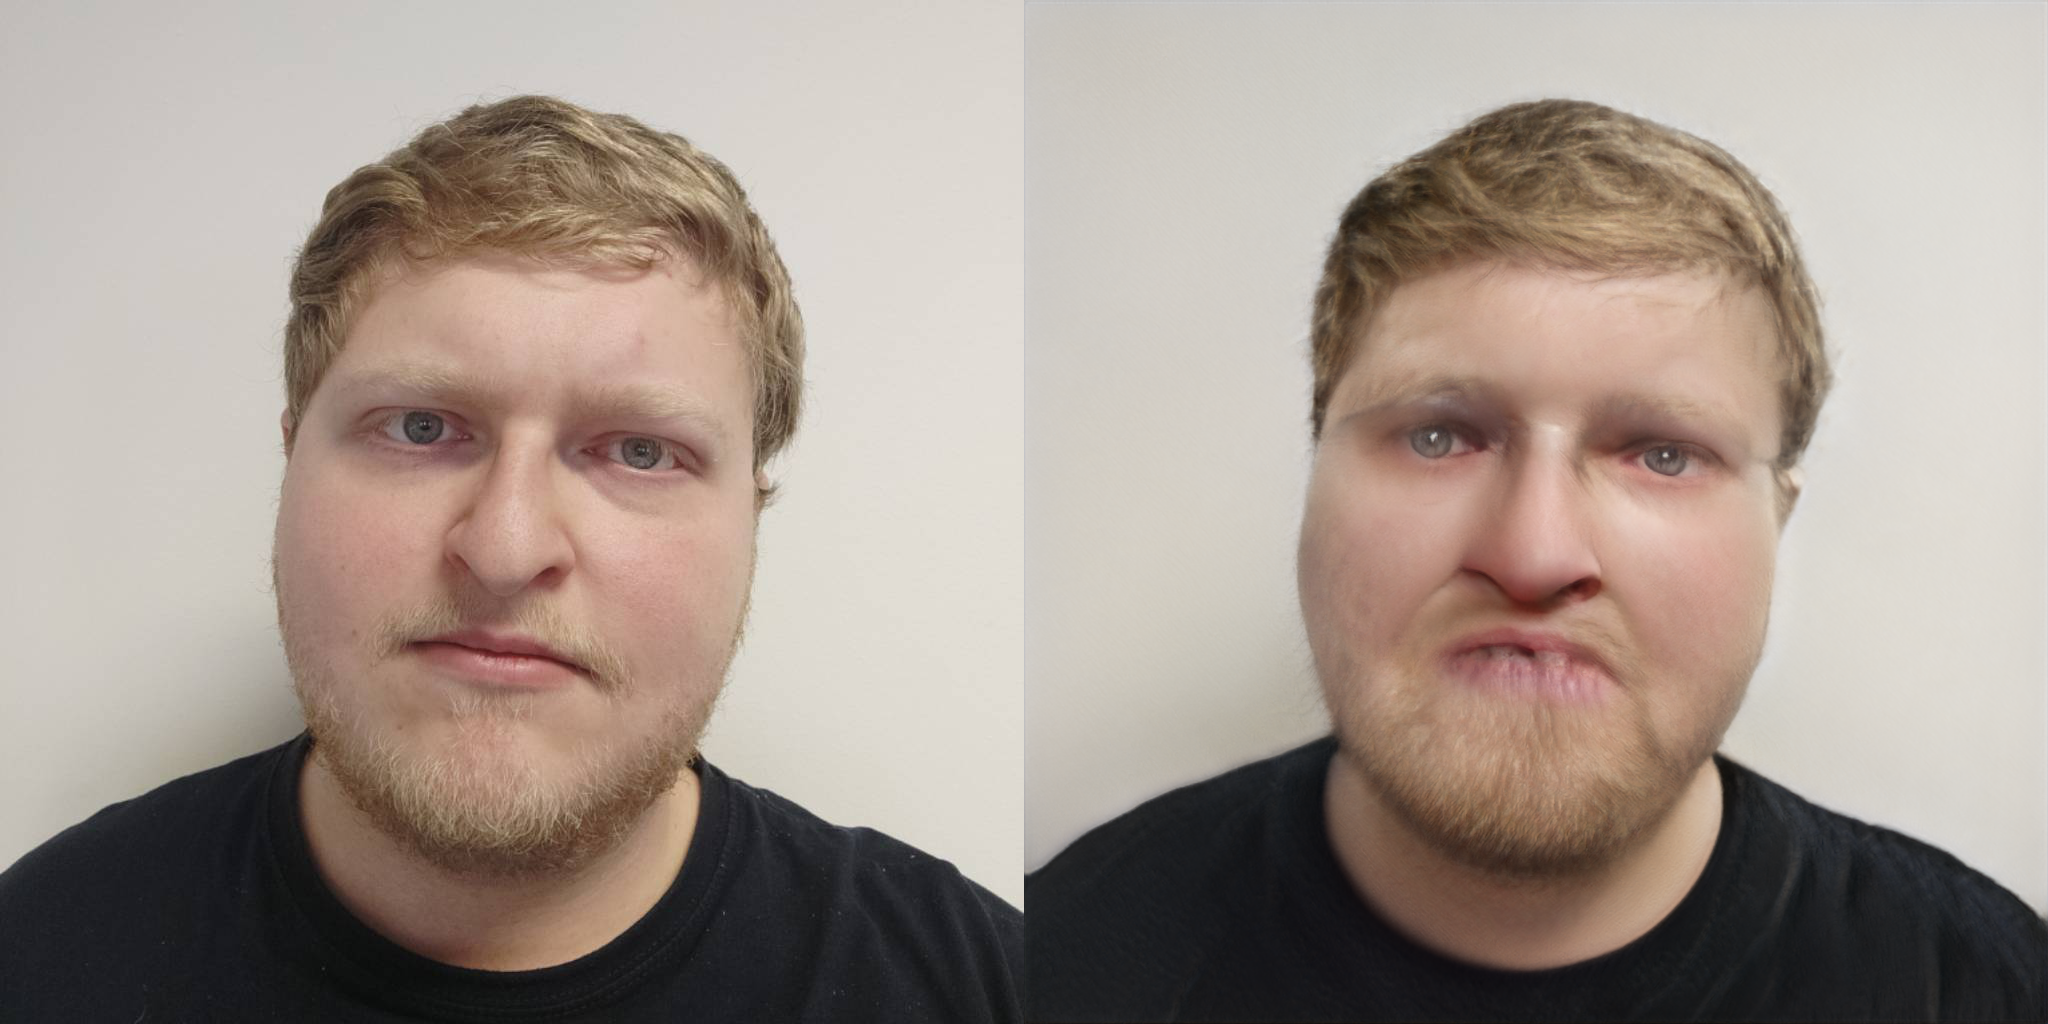

In [30]:
#@title { display-mode: "form" } 
resize_amount = (256, 256) if opts.resize_outputs else (opts.output_size, opts.output_size)

# final_res = tensor2im(images[0]).resize(resize_amount)
res = Image.fromarray(images[99])
res

In [16]:
kwargs = {'fps': 15}
save_path = "./notebooks/animations"
os.makedirs(save_path, exist_ok=True)

gif_path = os.path.join(save_path, f"{experiment_type}_gif")
generate_mp4(gif_path, images, kwargs)
show_mp4(gif_path, width=opts.output_size)

NameError: name 'imageio' is not defined

Finished running alignment on image: ./notebooks/images/foto1.jpg


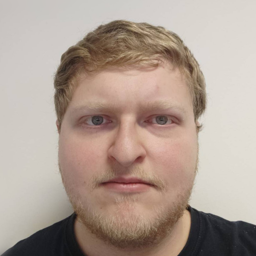

In [67]:
#@title Download (And Align) Image { display-mode: "form" }

# image_path = "./notebooks/images/domain_adaptation.jpg" #@param {type:"string"}
image_path = "./notebooks/images/foto1.jpg" #@param {type:"string"}

input_is_aligned = False #@param {type:"boolean"}
if not input_is_aligned:
    input_image = run_alignment(image_path)
else:
    input_image = Image.open(image_path).convert("RGB")

input_image.resize((256, 256))

## Run Inference

In [68]:
#@title { display-mode: "form" } 
img_transforms = transforms.Compose([transforms.Resize((256, 256)), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transformed_image = img_transforms(input_image)

restyle_e4e_opts.n_iters_per_batch = 5
restyle_e4e_opts.resize_outputs = False
opts.n_iters_per_batch = 5
opts.resize_outputs = False  # generate outputs at full resolution

with torch.no_grad():
    tic = time.time()
    result, _ = run_domain_adaptation(transformed_image.unsqueeze(0).cuda(), 
                                      net, 
                                      opts, 
                                      fine_tuned_generator, 
                                      restyle_e4e, 
                                      restyle_e4e_opts)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.5074 seconds.


## Visualize Result

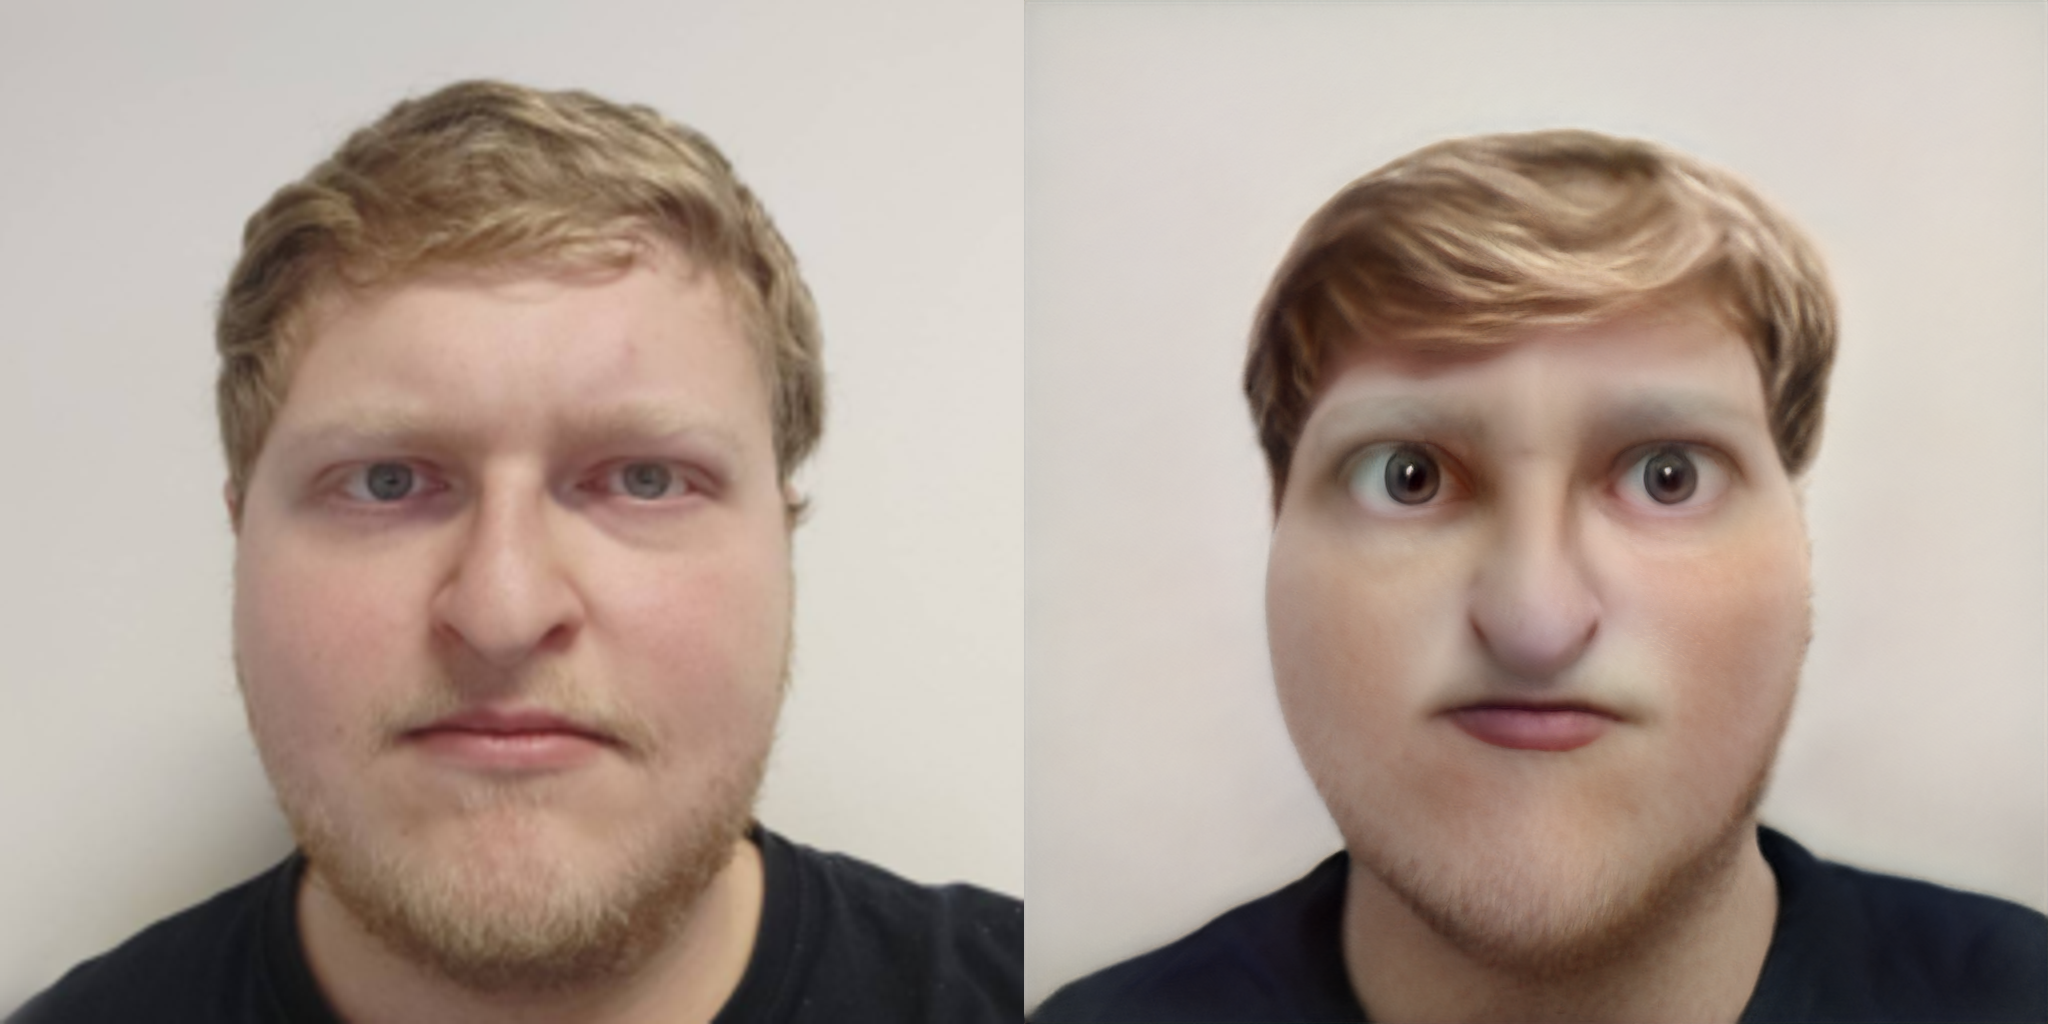

In [69]:
#@title { display-mode: "form" } 
resize_amount = (256, 256) if opts.resize_outputs else (opts.output_size, opts.output_size)

final_res = tensor2im(result[0]).resize(resize_amount)
input_im = tensor2im(transformed_image).resize(resize_amount)
res = np.concatenate([np.array(input_im), np.array(final_res)], axis=1)
res = Image.fromarray(res)
res

## Save Result

In [70]:
#@title { display-mode: "form" } 
outputs_path = f"./outputs/domain_adaptation/{generator_type}"
os.makedirs(outputs_path, exist_ok=True)
res.save(os.path.join(outputs_path, os.path.basename(image_path)))